In [2]:
import json
import gzip
import numpy as np
import pandas as pd

from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import seaborn as sns


import datetime

from collections import Counter

# Video Metadata

In this part, we focus on processing the video metadata file. Two goals are to be achieved: 

1) **Filter relevent videos**: This is the core step in our data processing pipeline which target videos regarding `Mental Health` are retrieved for further processing and visualization. At the same time, we plan to retrieve videoes of other topics so that comparison can be made between different trends to further validate our hypothesis.

2) **Visualize inner trend within target videos**: This is to explore how societies focus within mental health has transformed from 2015 to 2019, if we could acquire any deeper insights into the specific topic. Plots are expected to drawn in a meaningful way to support our ideas.

## Filter relevent videos

**Method (snowball keywords matching)**

The method we use to retrieve relevent videos is based on the string matching of keywords. The idea is that:

1) We design a list of keywords ourselves that is supposed to connect to the filed of mental health, e.g. `mental health`, `anxiety`, `depress`...
2) Since the dataset is extremely large, we read the files line by line and process them in a batch size of 200000. Three attributes are taken into account during processing, namely `description`, `tags` and `title`. If **at least two out of three text fields** contain a word in our designed word list, we assume that video is relevent and be retrieved. We adopt the function `pd.Dataframe.str.contains` to check the existence of the keywords.
3) After retrieving, we check the results manually and see if there is any insightful words that occur in the result but is not included in our designed keyword list. If such word exists, we iteratively add them to the list and repeat the process 1-3 to update the results until no new words can be found.

It takes a long time to process through the data, so we cannot do the loop many times, further improvement on the topic may include improving keyword list quality, adopting stemming on words for better matching, etc.

### 1. First Filter (Match based on keywords)

Aside from the target videos reagarding mental health, we also aim to retrieve videos of three types:

- Long-term trendy videos: This type of videos is the result of a long-term social trend, reflecting the raising awareness of some profound topics, e.g. `gender equality`, `climate change`. These topics enjoy a long-lasting attention and a steady increase in terms of YouTube videos. We hypothesize that `mental health` should belongs to such topic.

- Short-term trendy videos: This type of videos represents a very fashionable impulse on people posting same kind of videos just because other people are also doing it. The heat may be extreme at the moment but may not last long. Example such as `ice bucket challenge`, etc.

- Control group videos: This type of videos had not been brought to the spot of light during 2015-2019, but nonetheless we may still observe a growth in the number of videos on YouTube because the user growth and prevelant influence of digitilization.

We would like to compare the trend of the three types of videos and see if any interesting conclusion may be drawn from the results.

In [ ]:
# keywords for mental health
# The matching algorithm only checks the existence of the given string, 
# so we could use "depress" to represent "depression",# "depressed",# "depressing", etc.

mental_word_list = [
    "mental health",
    "mental illness",
    "solitude",
    "alone",
    "lonely",
    "loneliness",
    "depress"  # "depression",# "depressed",# "depressing",
    "stress"  # "stress", # "stressing",# "stressed"
    "anxiety",
    "anxious",
    "suicide",
    "suicidal",
    "trauma",
    "ptsd",
    "[^a-z0-9]emo[^a-z0-9]",
    "psycho",
    "psychiatr"
    "disorder" # new
]

mental_keywords = "|".join(mental_word_list)

In [ ]:
# keywords for gender quality
gender_word_list = [
    "gender equal",
    "gender inequal",
    "gender discriminat",
    "sex equal",
    "sex inqual"
    "sex discriminat",
    "sexis",
    "gender egalitari",
    "sexual egalitari",
    "sex egalitari",
    "sexual equal",
    "sexual inequal",
    "sexual discriminat",
    "sexual harass",
    "sexual assult",
    "feminis",  # "Feminism", "Feminist"
    "women right", "women's right", "women right", "women's right",
    "women power", "women's power", "women power", "women's power",
    "girl help girl", "girls help girls", "girl helps girl"
]

gender_keywords = "|".join(gender_word_list)

In [ ]:
chaplin_keywords = "charles spencer chaplin|charlie chaplin|charles chaplin"
comedy_keywords = "comedy|comedian"
babylon_keywords = "babylon"
equality_keywords = "equal|discriminat|egalitari"

ice_keywords = "ice bucket challenge|ALS challenge|ALS ice bucket|"

pokemon_keywords = "pokemon go|pokémon go"

black_keywords = "black friday"

word_lists_climate = [
    "climate change",
    "global warming",
    "air pollution",
    "greenhouse effect",
    "carbon emissions",
    "carbon footprint",
    "carbon tax"
]
climate_keywords = "|".join(word_lists_climate)


In [ ]:
keywords_dict = {
    "mental": mental_keywords,
    "gender_fem": gender_keywords,
    "comedy": comedy_keywords,
    "equality": equality_keywords,
    "chaplin": chaplin_keywords,
    "babylon": babylon_keywords,
    "ice": ice_keywords,
    "pokemon": pokemon_keywords,
    "black_friday": black_keywords,
    "climate": climate_keywords
}

In [40]:
##### Relevent videos retrieval ####
def df_filter(df_metadata: pd.DataFrame, keywords: str):
    """
    Function to build and filter dataframe.
    A record would be kept if at least two out of three text fields (description, tags, title) match with at least one keyword specifed above
    """

    df_meta = df_metadata.copy()
    df_meta = df_meta.dropna(subset=["description", "tags", "title", "upload_date"])

    filter_condition1 = df_meta["description"].str.lower().str.contains(keywords).astype(int)
    filter_condition2 = df_meta["tags"].str.lower().str.contains(keywords).astype(int)
    filter_condition3 = df_meta["title"].str.lower().str.contains(keywords).astype(int)

    filter_condition = filter_condition1 + filter_condition2 + filter_condition3
    df_meta = df_meta[filter_condition >= 2]

    return df_meta.copy()

def get_counter(df_metadata: pd.DataFrame):
    """
    Count how many videos are uploaded per day.
    This is to calculate ratio for the following process.
    """
    df_meta = df_metadata.copy()
    df_meta = df_meta.dropna(subset=["upload_date"])

    df_meta["upload_date"] = pd.to_datetime(df_meta["upload_date"]).dt.to_period("D").astype(str)
    counter_dict = df_meta["upload_date"].value_counts().to_dict()
    
    return Counter(counter_dict)

In [ ]:
# initialize dataframe
metadata_df = {}
for topic in keywords_dict.keys():
    metadata_df[topic] = []

tmp_metadata = []
counter = Counter()  # count how many videos uploaded per day

# Specify the file path and batch size
file_path = './data/yt_metadata_en.jsonl.gz'
batch = 200000

with gzip.open(file_path, mode="rb") as f:
    for idx, row in enumerate(tqdm(f, total=72924794)):
        json_dict = json.loads(row.decode("utf-8"))
        tmp_metadata.append(json_dict)

        if (idx + 1) % batch == 0 and idx != 0:
            df_meta = pd.DataFrame(tmp_metadata)
            cur_counter = get_counter(df_meta)
            counter = counter + cur_counter

            for topic, keywords in keywords_dict.items():
                metadata_df[topic].append(df_filter(df_meta, keywords))
            tmp_metadata = []
    
    if tmp_metadata:
        df_meta = pd.DataFrame(tmp_metadata)
        cur_counter = get_counter(df_meta)
        counter = counter + cur_counter
        
        for topic, keywords in keywords_dict.items():
            metadata_df[topic].append(df_filter(df_meta, keywords))
        tmp_metadata = []

### 2. Second filter based on category type
We eliminate some categories like `Music`, `Movie` since a lot of music and movie titles may cotain keywords like `lonely`, `alone` which would result in a lot of false positve, so it is better to filter them before further processing.

In [2]:
# Second step filtering depending on the video category
constrained_category = ["Howto & Style", "Science & Technology", "People & Blogs",
                        "Travel & Events", "Entertainment", "Nonprofits & Activism",
                        "News & Politics", "Education", "Nonprofits & Activism"] 

df_meta_mental = pd.read_csv("./metadata_mental.csv")
print("Before filtering, there are %d videos"%len(df_meta_mental))

# drop nan and filter nan
df_meta_mental = df_meta_mental.dropna(subset=["description", "tags", "title", "upload_date", "categories"])
df_meta_mental = df_meta_mental[df_meta_mental["categories"].isin(constrained_category)]
print("After filtering, there are %d videos"%len(df_meta_mental))

# save the result
df_meta_mental.to_csv("./metadata_mental_best.csv", index=False)

Before filtering, there are 252731 videos
After filtering, there are 147273 videos


### 3. Wordcloud analysis

Are the video records we extracted meet our expections focusing on mental health problems? What other possible keywords could we add to the list for topic retrieval? To answer these questions, we run an wordcloud generation on the tags of videos we obtained and see what are the most frequent words:

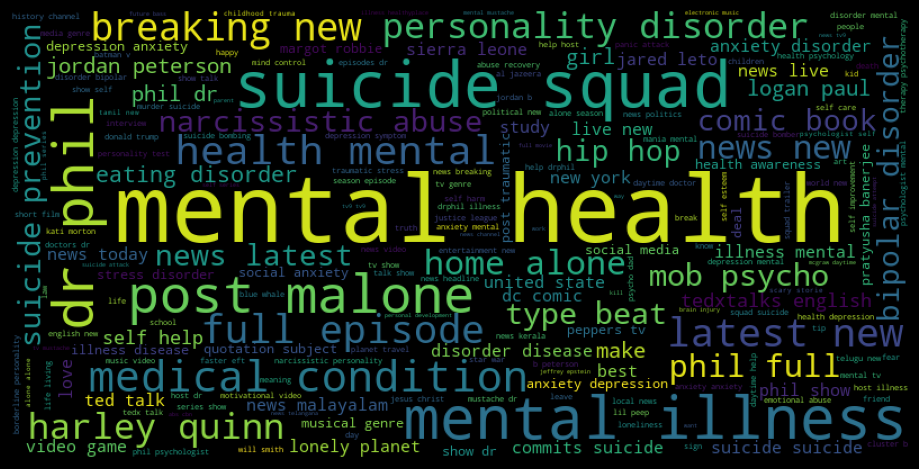

In [3]:
# add disorder to the key
from wordcloud import WordCloud, STOPWORDS

df_meta_mental = pd.read_csv("./metadata_mental_best.csv")
df_meta_mental = df_meta_mental.dropna(subset=["tags"])
df_meta_mental["tags"] = df_meta_mental["tags"].apply(lambda x: str(x).lower().replace(",", " "))
wordcloud = WordCloud(width=800, height=400, stopwords=STOPWORDS).generate(' '.join(df_meta_mental['tags']))

plt.figure(figsize=(9,6), facecolor='k')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

From the graph, we see `meantal health` taking up the majority among the tags, justifying our extracted result. At the same time, it is interesting to find out that `disorder`, `narcissistic`, `abuse` consists of a large proportion in the tags which we overlook at first filtering the videos. So we may discuss and add them to the list above later. 

### 4. Number of mental health videos uploaded per day from 2006-2019

Finally it is time to show how much videos about mental health are uploaded per month and how much they grow over the years.

As shown in the figure, the growing video numbers regarding mental health indicates an increasing social attention in this topic. However, to be clearer about this, we need to further compare the trend with other topics and be sure it is not just because of general user growth in YouTube instead. 

Also, it it may be interesting to investiage further into the peaks (`2018.11`, `2016.7`...) in the graph to understand the cause. Could it be a relevant influencial event hosting in that month? Does it occur in any seasonal patterns? This are several points we want to look further in the final project.

In [4]:
def get_total_count(path):
    """
    Function to get total uploaded video number per date
    """
    total_count = pd.read_csv(path)
    total_count['upload_date'] = pd.to_datetime(total_count['upload_date'])

    total_count['upload_month'] = total_count['upload_date'].dt.to_period('M')
    total_count = total_count.groupby('upload_month')['value'].sum()#.to_dict()
    
    return total_count

def get_proportion(dataframe: pd.DataFrame, total_count: pd.Series):
    """
    Function to get the proportion of current topic videos to all videos uploaded in the same month
    """
    df = dataframe.copy()

    df["upload_month"] = pd.to_datetime(df["upload_date"]).dt.to_period('M')
    cur_count = df["upload_month"].value_counts()

    percentage = cur_count / total_count
    percentage = percentage.dropna()

    return percentage

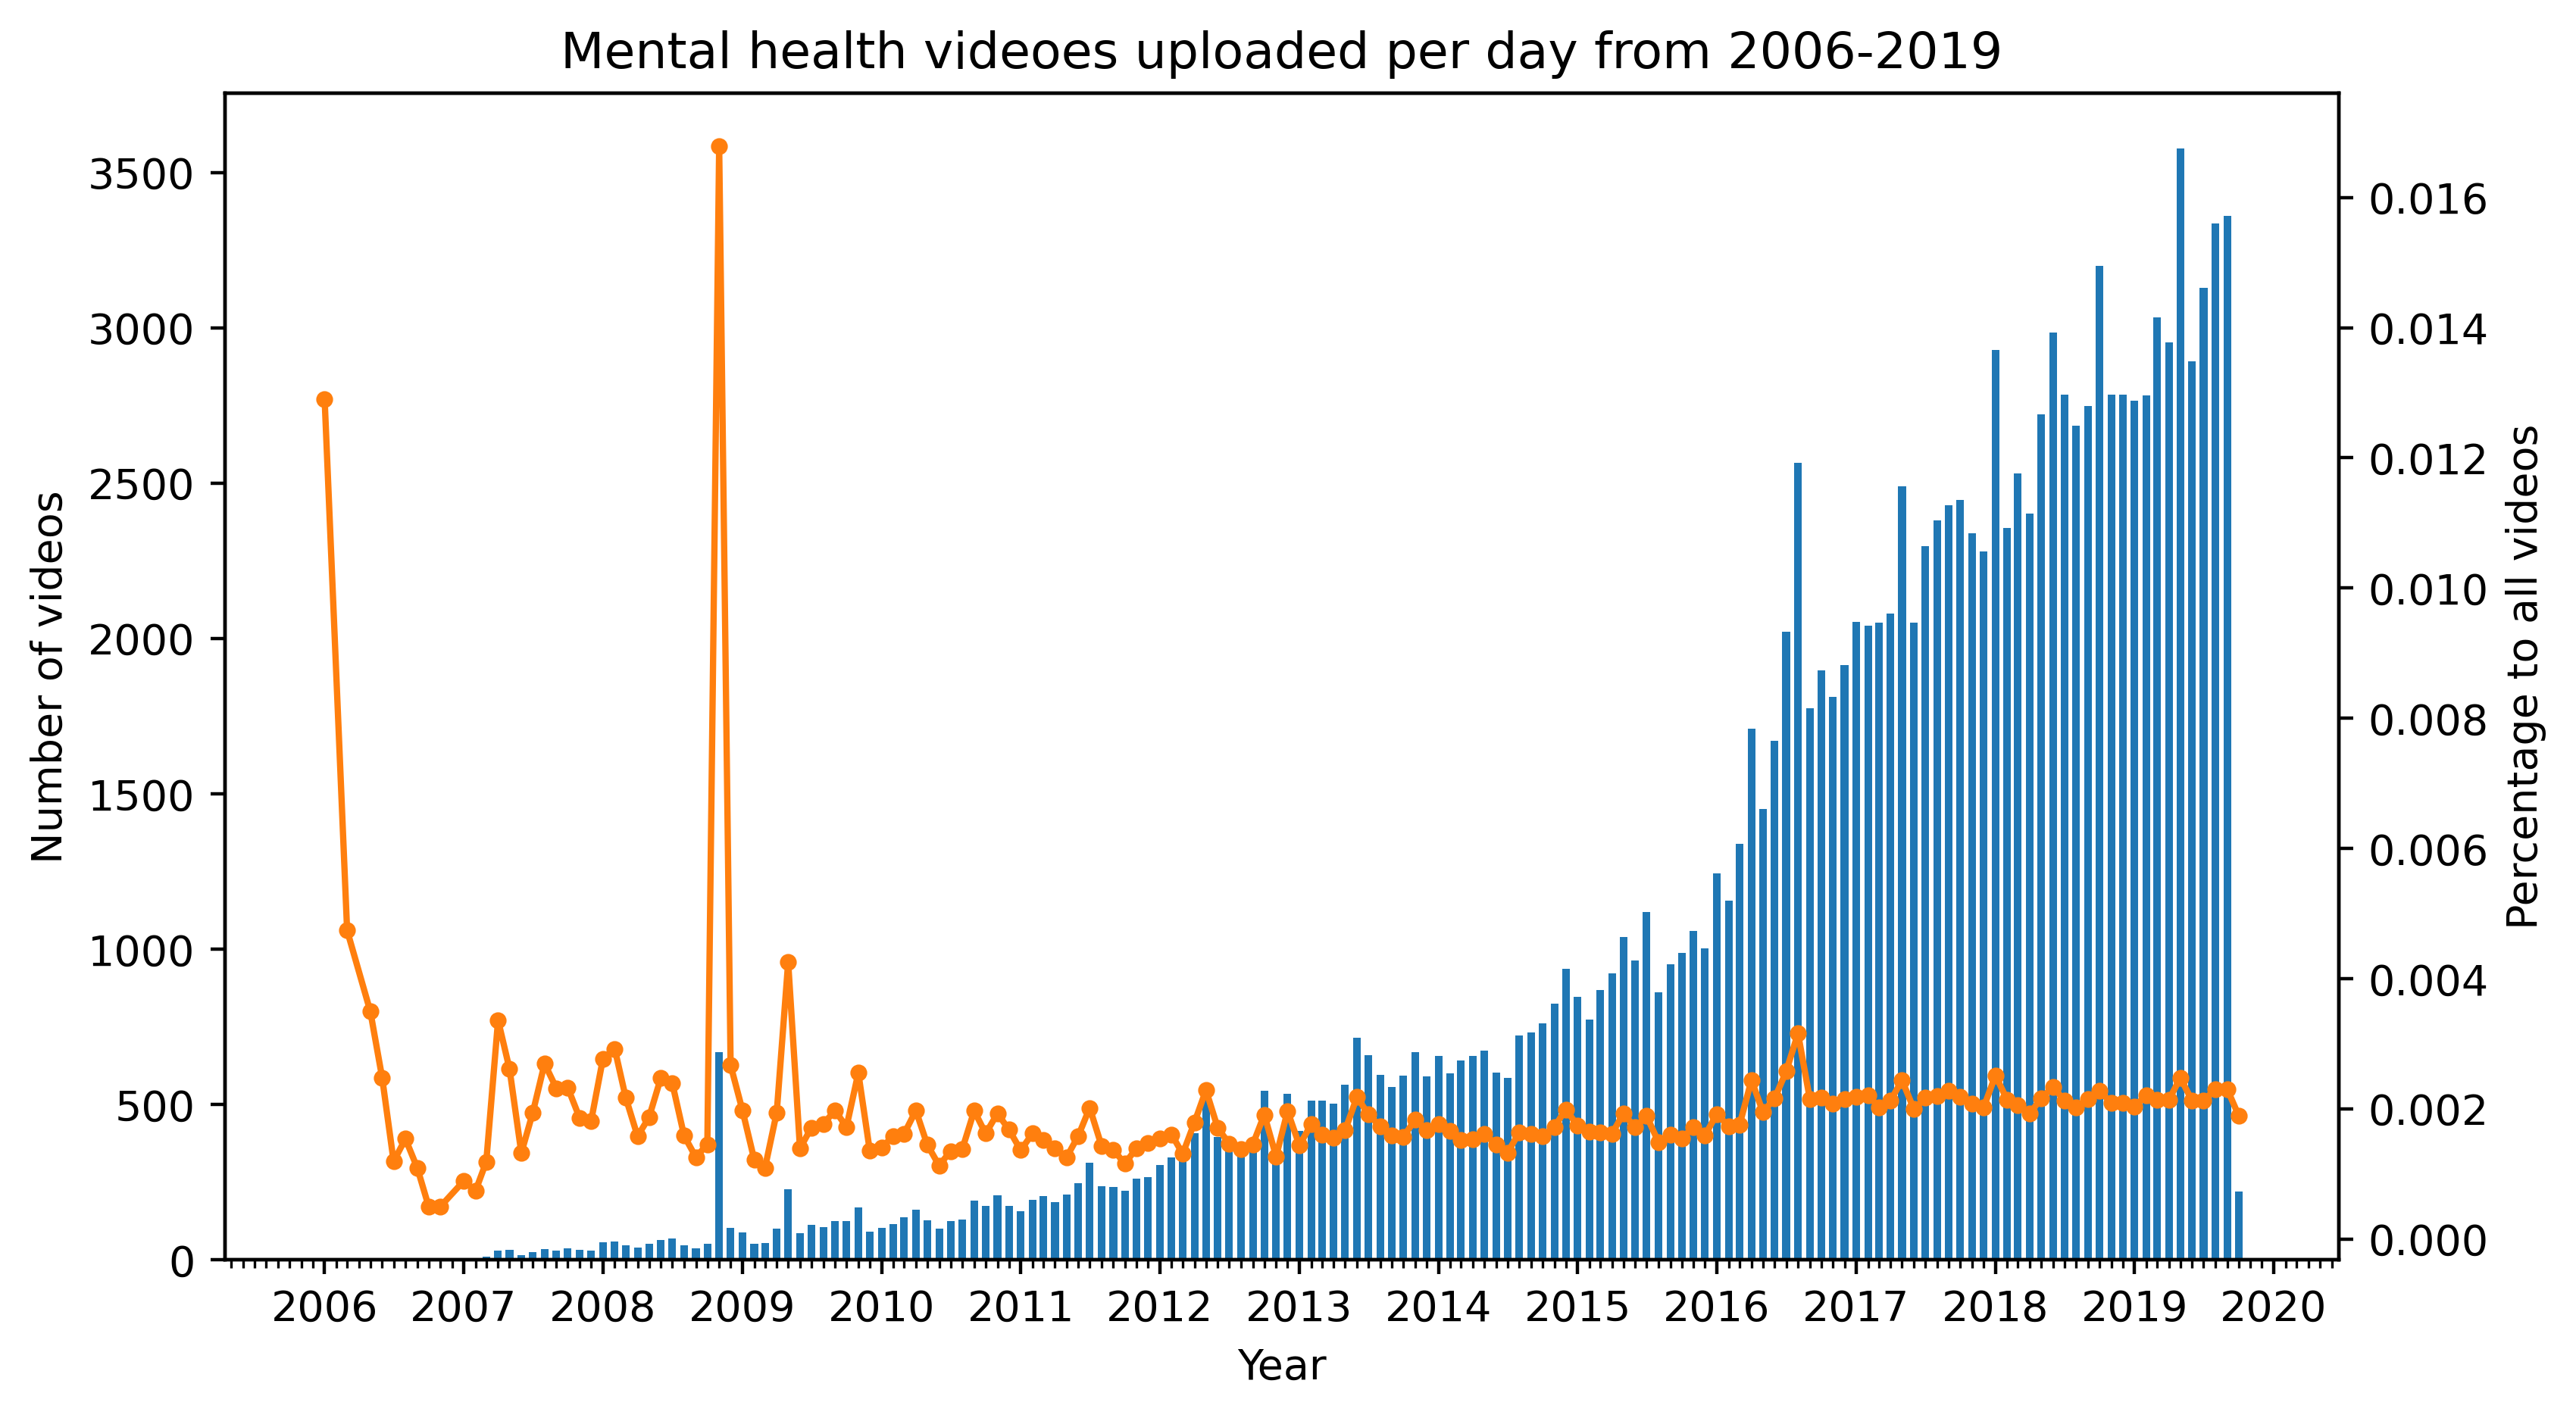

In [5]:
# aggregate based on upload time and plot the histogram
def transform_for_histplot(dataframe: pd.DataFrame):
    """
    Aggregate record numbers monthly based on upload_date
    Return sorted hitogram series
    """
    df = dataframe.copy()
    df.upload_date = pd.to_datetime(df.upload_date)
    df['upload_month'] = df['upload_date'].dt.to_period('M')
    df_hist = df['upload_month'].value_counts().sort_index()
    df_hist.index = df_hist.index.to_timestamp()
    return df_hist

df_meta_mental = pd.read_csv("./metadata_mental_best.csv")

fig, ax = plt.subplots(figsize=(9, 5), dpi=400)
ax.xaxis.set_major_locator(matplotlib.dates.YearLocator())
ax.xaxis.set_minor_locator(matplotlib.dates.MonthLocator())

ax.set_xbound(datetime.date(2006, 1, 1), datetime.date(2019, 11, 1))

# First plot, absolute size
mental_hist = transform_for_histplot(df_meta_mental)
ax.bar(mental_hist.index, mental_hist.values, width=20)

ax.set_xlabel("Year")
ax.set_ylabel("Number of videos")
ax.set_title("Mental health videoes uploaded per day from 2006-2019")

# Second plot, percentage
total_count = get_total_count("./total_count.csv")
mental_percentage = get_proportion(df_meta_mental, total_count)

ax2 = ax.twinx()
ax2.set_ylabel("Percentage to all videos")
ax2.plot(mental_percentage.index.to_timestamp(), mental_percentage.values, marker='.', color='tab:orange')

### 5. Comparing the trend with other topics
It is time to compare the uploaded video numbers to other topics: ["gender_fem", "pokemon", "ice", "babylon", "comedy", "equality"]

For better visualization, we adopt line plot instead of bar plot this time.

In [6]:
def load_dataframe(topics: list):
    """
    Load csv files of other topics into dataframes
    """
    df_dict = {}
    for topic in topics:
        df_dict[topic] = pd.read_csv("./metadata_%s.csv"%topic)
    return df_dict

compared_topics = ["gender_fem", "pokemon", "ice", "babylon", "comedy", "equality", "black_friday", "climate"] # chaplin
df_dict = load_dataframe(compared_topics)

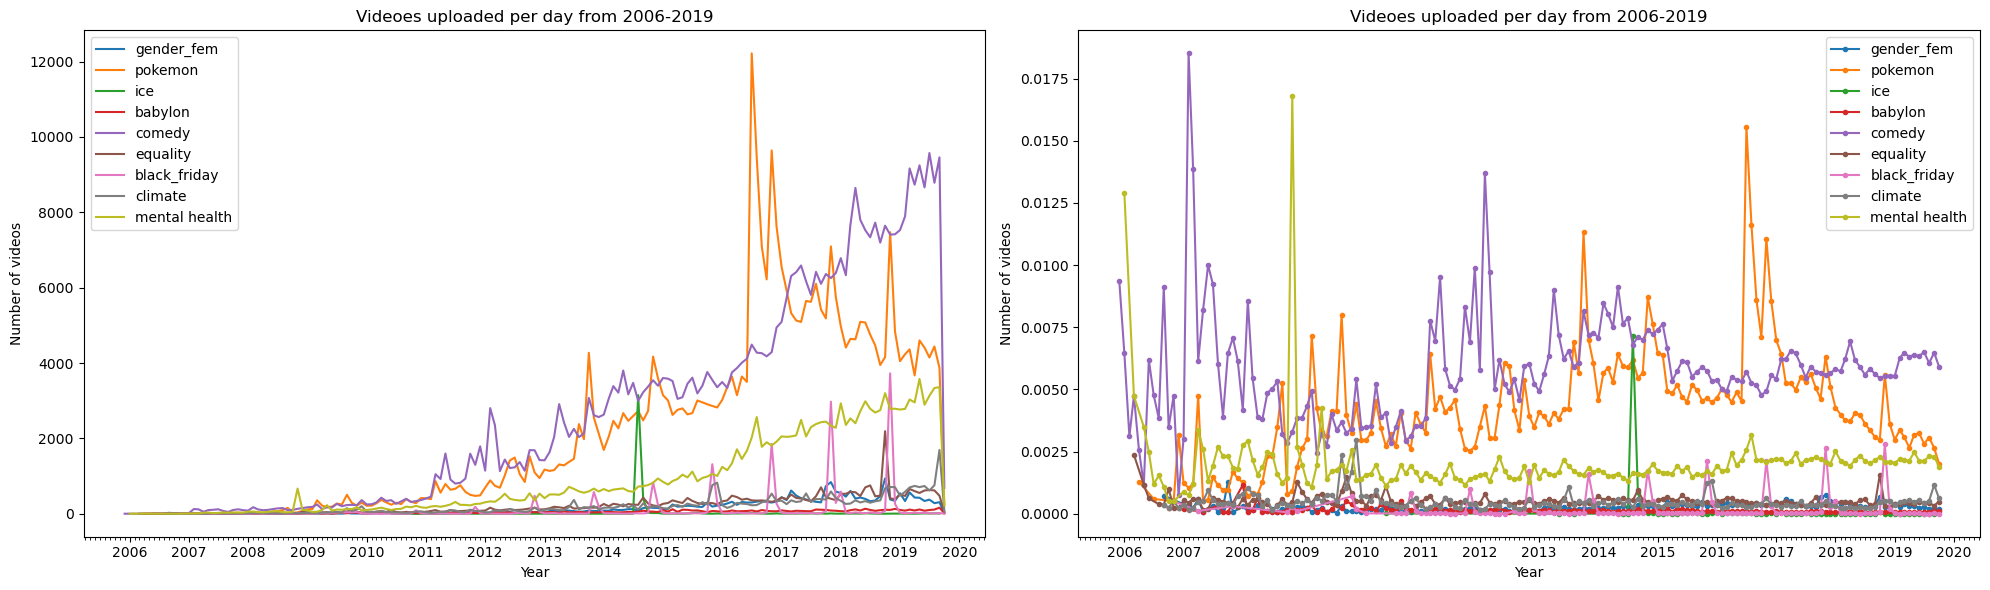

In [7]:
plt.figure(figsize=(20, 6))

# Plot the first subplot
ax = plt.subplot(1, 2, 1)

ax.xaxis.set_major_locator(matplotlib.dates.YearLocator())
ax.xaxis.set_minor_locator(matplotlib.dates.MonthLocator())

ax.set_xlabel("Year")
ax.set_ylabel("Number of videos")
ax.set_title("Videoes uploaded per day from 2006-2019")

ax.set_xbound(datetime.date(2006, 1, 1), datetime.date(2019, 11, 1))

for topic, df_topic in df_dict.items():

    # if topic in ["pokemon", "comedy"]:
    #     continue

    topic_hist = transform_for_histplot(df_topic)
    ax.plot(topic_hist, label=topic)

ax.plot(mental_hist, label="mental health")
ax.legend()

# Plot the second subplot
ax = plt.subplot(1, 2, 2)

ax.xaxis.set_major_locator(matplotlib.dates.YearLocator())
ax.xaxis.set_minor_locator(matplotlib.dates.MonthLocator())

ax.set_xlabel("Year")
ax.set_ylabel("Number of videos")
ax.set_title("Videoes uploaded per day from 2006-2019")

ax.set_xbound(datetime.date(2006, 1, 1), datetime.date(2019, 11, 1))

for topic, df_topic in df_dict.items():

    # if topic in ["pokemon", "comedy"]:
    #     continue

    topic_percentage = get_proportion(df_topic, total_count)
    ax.plot(topic_percentage.index.to_timestamp(), topic_percentage.values, marker='.', label=topic)

ax.plot(mental_percentage.index.to_timestamp(), mental_percentage.values, marker='.', label="mental health")
ax.legend()

plt.tight_layout()
plt.show()

### 6. Explore predominant category in mental health videos
We divide the keywords into several categories according to our best knowledge, and calculate their frequency according to their appearance in the mental health videos. Patterns of these keywords may reveal some underlying factors determining the change of mental health videos.

In [8]:
df_meta_mental = pd.read_csv("./metadata_mental_best.csv")

# mental health types
mental_types = {
    # "general": ["mental health", "mental illness", "[^a-z0-9]emo[^a-z0-9]", "psycho", "psychiatr"],
    "lonely": ["solitude", "alone", "lonely", "loneliness"],
    "depress": ["depress"],
    "stress": ["stress",  "anxiety", "anxious"],
    "suicide": ["suicid"],
    "trauma": ["trauma", "ptsd"],
    "disorder": ["disorder"], # new
}

for m_type, keywords in mental_types.items():
    mental_types[m_type] = "|".join(keywords)

It is surprising to see that `suicide` takes up the majority within the specific categories, followed by `general` and `lonely`.

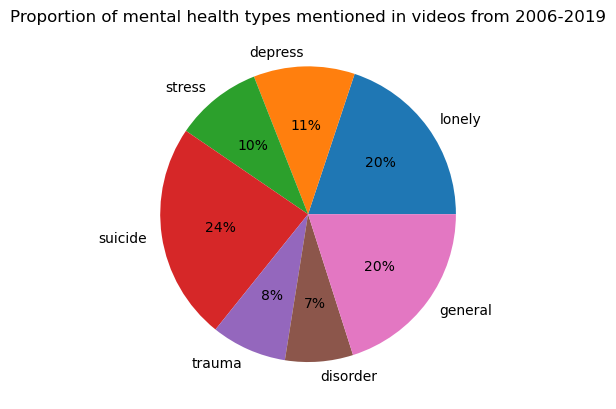

In [9]:
def count_type(dataframe: pd.DataFrame, mental_types: dict):
    """
    Count the occurence of each type
    If none of the types is detected, then it belongs to the general type
    """
    df = dataframe.copy()

    df["text"] = df["description"] + " " + df["tags"] + " " + df["title"]
    df["is_general"] = 1

    keywords_counter = Counter()

    for m_type, keywords in mental_types.items():
        if_contains_keywords = df["text"].str.lower().str.contains(keywords)

        keywords_counter[m_type] = if_contains_keywords.astype(int).sum()
        df.loc[if_contains_keywords, "is_general"] = 0

    keywords_counter["general"] = df["is_general"].sum()

    return keywords_counter

df_meta = df_meta_mental.copy()
types_counter = count_type(df_meta, mental_types)

# plot a bie chart for visualization
plt.title("Proportion of mental health types mentioned in videos from 2006-2019")
plt.pie(types_counter.values(), labels=types_counter.keys(), autopct='%.0f%%')
plt.show()

Also it would be interesting to see how the proportions are envolved during the years.

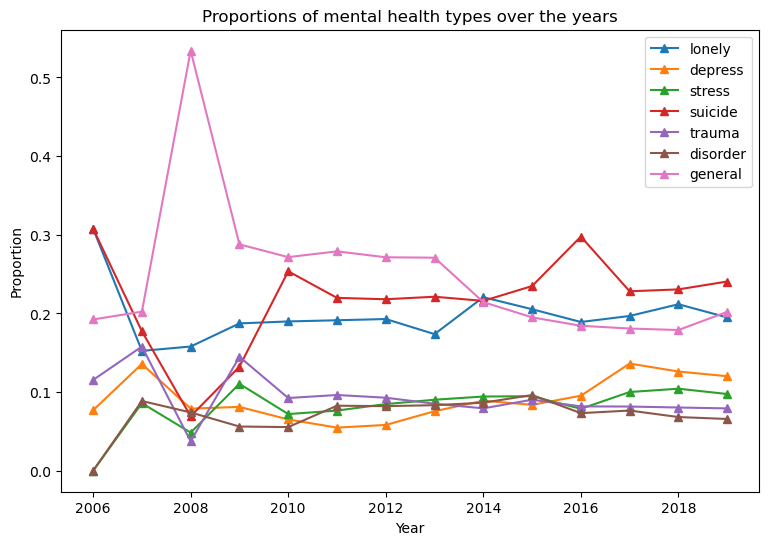

In [10]:
df_meta = df_meta_mental.copy()
df_meta["upload_date"] = pd.to_datetime(df_meta["upload_date"])

# initialize, keys are types, values are lists of proportion over the years
types_proportion_all = {}
for mental_type in mental_types.keys():
    types_proportion_all[mental_type] = []
types_proportion_all["general"] = []

# group by years
years = []
for year, df_group in df_meta.groupby(df_meta["upload_date"].dt.year):
    years.append(year)
    types_counter = count_type(df_group, mental_types)
    types_proportion = list(types_counter.values()) / sum(types_counter.values())
    for mental_type, proportion in zip(list(types_counter.keys()), types_proportion):
        types_proportion_all[mental_type].append(proportion)

plt.figure(figsize=(9, 6))

for mental_type, proportions in types_proportion_all.items():
    plt.plot(years, proportions, label=mental_type, marker='^')

plt.ylabel("Proportion")
plt.xlabel("Year")
plt.title("Proportions of mental health types over the years")
plt.legend()
plt.show()
